In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import altair as alt



from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA


In [2]:
student_df = pd.read_csv('../data/student.csv')

In [3]:
train_df_org, test_df_org = train_test_split(student_df, test_size=0.2, random_state = 123)

## Reduce feature space dimension based on Feature Importance & PCA

### Method1 Feature Importance Value

In [4]:
train_df_org.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
563,1,1,1,9130,1,1,132.0,1,19,38,...,0,6,9,5,13.2,0,8.9,1.4,3.51,Graduate
509,1,1,2,9147,1,1,125.0,1,1,19,...,0,5,5,0,0.0,0,15.5,2.8,-4.06,Dropout
2995,1,17,5,9500,1,1,137.0,1,1,1,...,0,8,8,8,14.9,0,13.9,-0.3,0.79,Graduate
1916,1,17,5,9500,1,1,136.0,1,19,38,...,0,7,7,6,12.6,0,7.6,2.6,0.32,Graduate
3389,1,43,1,9238,1,1,109.0,1,19,37,...,0,6,8,5,12.4,0,10.8,1.4,1.74,Enrolled


In [5]:
X_train_new = train_df_org.drop(columns = ['Target'])
y_train_new = train_df_org['Target']

                                           feature  importance
30             Curricular units 2nd sem (approved)    0.150843
31                Curricular units 2nd sem (grade)    0.091830
24             Curricular units 1st sem (approved)    0.089915
25                Curricular units 1st sem (grade)    0.067837
12                                 Admission grade    0.044475
16                         Tuition fees up to date    0.040033
29          Curricular units 2nd sem (evaluations)    0.040025
6                   Previous qualification (grade)    0.038404
19                               Age at enrollment    0.038358
23          Curricular units 1st sem (evaluations)    0.035133
3                                           Course    0.034603
11                             Father's occupation    0.029859
10                             Mother's occupation    0.026861
35                                             GDP    0.023918
33                               Unemployment rate    0

/Users/tangyili/miniconda3/envs/522_lab1/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


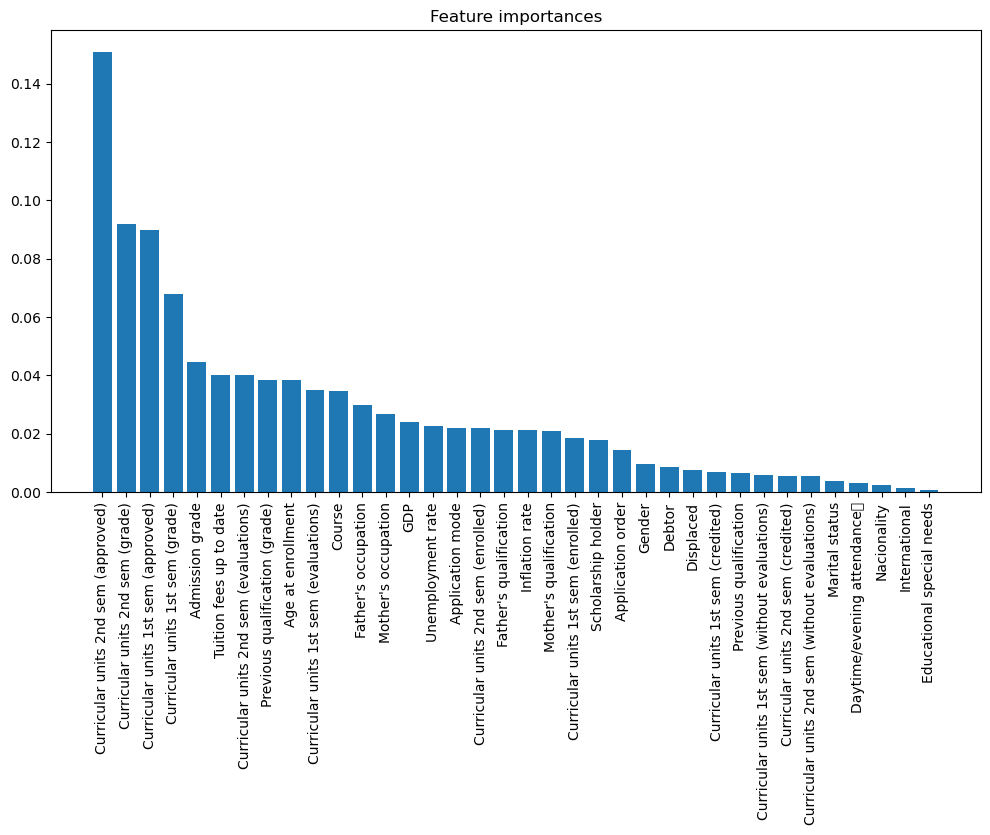

In [6]:

rf = RandomForestClassifier(n_estimators=100, random_state=123)
rf.fit(X_train_new, y_train_new)

importances = rf.feature_importances_

feature_importances = pd.DataFrame({'feature': X_train_new.columns, 'importance': importances})

feature_importances = feature_importances.sort_values(by='importance', ascending=False)


print(feature_importances)


plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation='vertical')
plt.show()


In [7]:
new_columns = list(feature_importances.query('importance >= 0.01')['feature'])

In [8]:
drop_columns = []

for i in train_df_org.columns:
    if i not in new_columns:
        drop_columns.append(i)

In [9]:
drop_columns = drop_columns[:-1]
drop_columns

['Marital status',
 'Daytime/evening attendance\t',
 'Previous qualification',
 'Nacionality',
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Gender',
 'International',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (without evaluations)']

In [10]:
len(drop_columns)

13

In [11]:
numeric_features_new = ['Previous qualification (grade)', 
       'Admission grade', 
       'Age at enrollment', 
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 
       'Unemployment rate',
       'Inflation rate', 
       'GDP']
categorical_features_new = [ 
                        'Application mode', 
                        'Course', 
                        "Mother's occupation", 
                        "Father's occupation"]

ordinal_features_new = ['Application order', 
                    "Mother's qualification", 
                    "Father's qualification"]

binary_features_new = [ 
                   'Tuition fees up to date', 
                   'Scholarship holder']



target = "Target"


In [12]:
### Based on correlation matrix in EDA, I drop columns with spearman correlation greater than 0.8
drop_columns_new = drop_columns + ['Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (approved)']

In [13]:
drop_columns_new.remove('Daytime/evening attendance\t')

In [14]:
drop_features = drop_columns_new + ['Daytime evening attendance']

In [15]:
### Map the marital status from code to actual status
### Categorical variable
status_mapping = {
    1: 'single',
    2: 'married',
    3: 'widower',
    4: 'divorced',
    5: 'facto union',
    6: 'legally separated'
}


train_df_org['Marital status'] = train_df_org['Marital status'].map(status_mapping)
test_df_org['Marital status'] = test_df_org['Marital status'].map(status_mapping)

In [16]:
### Map the Course from code to actual Course type easier for interpretation
### Categorical variable

course_mapping = {
    33: 'Biofuel Production Technologies',
    171: 'Animation and Multimedia Design',
    8014: 'Social Service (evening attendance)',
    9003: 'Agronomy',
    9070: 'Communication Design',
    9085: 'Veterinary Nursing',
    9119: 'Informatics Engineering',
    9130: 'Equinculture',
    9147: 'Management',
    9238: 'Social Service',
    9254: 'Tourism',
    9500: 'Nursing',
    9556: 'Oral Hygiene',
    9670: 'Advertising and Marketing Management',
    9773: 'Journalism and Communication',
    9853: 'Basic Education',
    9991: 'Management (evening attendance)'
}

# Apply the mapping
train_df_org['Course'] = train_df_org['Course'].map(course_mapping)
test_df_org['Course'] = test_df_org['Course'].map(course_mapping)


In [17]:
### Map the Course day/night attendance type easier for interpretation
### binary variable

course_mapping = {
    0: 'evening',
    1: 'daytime',
}

# Apply the mapping
train_df_org['Daytime/evening attendance\t'] = train_df_org['Daytime/evening attendance\t'].map(course_mapping)
test_df_org['Daytime/evening attendance\t'] = test_df_org['Daytime/evening attendance\t'].map(course_mapping)
train_df_org.rename(columns={'Daytime/evening attendance\t': 'Daytime evening attendance'}, inplace=True)
test_df_org.rename(columns={'Daytime/evening attendance\t': 'Daytime evening attendance'}, inplace=True)



In [18]:
X_train = train_df_org.drop(columns=["Target"])
X_test = test_df_org.drop(columns=["Target"])
y_train = train_df_org["Target"]
y_test = test_df_org["Target"]

In [19]:
ordinal_transformer = OrdinalEncoder(dtype=np.int64, handle_unknown='use_encoded_value', unknown_value=-1)
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype = int, min_frequency=10)
numeric_transformer = StandardScaler()

In [20]:
preprocessor_new = make_column_transformer(
    ( numeric_transformer, numeric_features_new),  
    ( categorical_transformer, categorical_features_new+binary_features_new),  
    ( ordinal_transformer, ordinal_features_new),
    ("drop", drop_features)
)
preprocessor_new

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Previous qualification (grade)',
                                  'Admission grade', 'Age at enrollment',
                                  'Curricular units 1st sem (evaluations)',
                                  'Curricular units 1st sem (grade)',
                                  'Curricular units 2nd sem (enrolled)',
                                  'Curricular units 2nd sem (evaluations)',
                                  'Curricular units 2nd sem (approved)',
                                  'Curricular units 2nd sem (grade)',
                                  'Unemploymen...
                                 ['Marital status', 'Previous qualification',
                                  'Nacionality', 'Displaced',
                                  'Educational special needs', 'Debtor',
                                  'Gender', 'International',
                                  'Curricular units 1st sem (credited)',
                                  'Curricular units 1st sem (without '
                                  'evaluations)',
                                  'Curricular units 2nd sem (credited)',
                                  'Curricular units 2nd sem (without '
                                  'evaluations)',
                                  'Curricular units 1st sem (enrolled)',
                                  'Curricular units 1st sem (approved)',
                                  'Daytime evening attendance'])])

In [21]:
preprocessor_new.verbose_feature_names_out = False

X_train_enc_new = pd.DataFrame(preprocessor_new.fit_transform(X_train))

column_name = numeric_features_new + preprocessor_new.named_transformers_['onehotencoder'].get_feature_names_out().tolist() + ordinal_features_new

X_train_enc_new.columns = column_name

X_train_enc_new.head()

,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (evaluations),Curricular units 1st sem (grade),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Unemployment rate,...,Father's occupation_99,Father's occupation_193,Father's occupation_infrequent_sklearn,Tuition fees up to date_0,Tuition fees up to date_1,Scholarship holder_0,Scholarship holder_1,Application order,Mother's qualification,Father's qualification
0,-0.040300,0.245415,-0.694386,-0.541173,0.593152,-0.104250,0.234793,0.181829,0.571300,-1.005346,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,12.0,23.0
1,-0.575696,-0.818901,-0.300945,-0.541173,-2.191899,-0.554728,-0.770569,-1.474949,-1.966330,1.484108,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,12.0
2,0.342125,0.399461,-0.694386,-0.305455,0.666830,0.796706,-0.016548,1.175896,0.898116,0.880604,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,0.0,0.0
3,0.265640,0.238413,-0.694386,-0.305455,0.407482,0.346228,-0.267888,0.513185,0.455953,-1.495693,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,12.0,23.0
4,-1.799457,-1.302045,-0.300945,1.580293,-0.025749,-0.104250,-0.016548,0.181829,0.417504,-0.288685,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,12.0,22.0


In [22]:
print("new column number after preprocessing is {}".format(X_train_enc_new.shape[1]))

new column number after preprocessing is 79


In [23]:
param_dist_rf_new = {
    "randomforestclassifier__n_estimators": randint(50, 200),   
    "randomforestclassifier__max_depth": randint(5, 15),
    "randomforestclassifier__min_samples_split": randint(5, 10),  
    "randomforestclassifier__min_samples_leaf": randint(5, 10), 
    
}


rf_pipe_new = make_pipeline(preprocessor_new, RandomForestClassifier(random_state=123))


rf_random_search_new = RandomizedSearchCV(
    rf_pipe_new, param_dist_rf_new, n_iter=100, n_jobs=-1, return_train_score=True, random_state=123
)


rf_random_search_new.fit(X_train, y_train)


best_search_param_rf_new = rf_random_search_new.best_params_
best_search_score_rf_new = rf_random_search_new.best_score_

best_search_param_rf_new, best_search_score_rf_new

({'randomforestclassifier__max_depth': 14,
  'randomforestclassifier__min_samples_leaf': 5,
  'randomforestclassifier__min_samples_split': 6,
  'randomforestclassifier__n_estimators': 118},
 0.7572791056345344)

In [24]:
param_dist_lr = {
    'logisticregression__C': uniform(0.01, 100.0), 
    'logisticregression__penalty': ['l2', 'l1'],  
}


lr_pipe_new = make_pipeline(preprocessor_new, LogisticRegression(max_iter=2000, random_state=123, solver='liblinear', multi_class="ovr"))


lr_random_search_new = RandomizedSearchCV(
    lr_pipe_new, param_dist_lr, n_iter=100, n_jobs=-1, cv=5, random_state=123
)


lr_random_search_new.fit(X_train, y_train)


best_params_lr_new = lr_random_search_new.best_params_
best_score_lr_new = lr_random_search_new.best_score_

best_params_lr_new, best_score_lr_new

({'logisticregression__C': 10.600848505681382,
  'logisticregression__penalty': 'l2'},
 0.7646229392915078)

In [25]:
param_dist_svc = {"svc__C": loguniform(1e-3, 1e1),
              "svc__gamma": loguniform(1e-3, 1e1)}

svc_pipe_new = make_pipeline(preprocessor_new, SVC(probability=True, random_state=123)) 

svc_random_search_new = RandomizedSearchCV(
    svc_pipe_new, param_dist_svc, n_iter=100, n_jobs=-1, cv=5, random_state=123)


svc_random_search_new.fit(X_train, y_train)


best_search_param_new = svc_random_search_new.best_params_
best_search_score_new = svc_random_search_new.best_score_

best_search_param_new, best_search_score_new

({'svc__C': 8.591845063663952, 'svc__gamma': 0.002077127528347042},
 0.7575607923988525)

In [26]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    scores = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='weighted'),
        "recall": recall_score(y_test, y_pred, average='weighted'),
        "f1": f1_score(y_test, y_pred, average='weighted'),
        "roc_auc": roc_auc_score(y_test, y_proba, multi_class="ovr")
    }
    return scores

In [27]:
models = {
    "RandomForest": rf_random_search_new.best_estimator_,
    "LogisticRegression": lr_random_search_new.best_estimator_,
    "SVC": svc_random_search_new.best_estimator_
}


test_results_new = {model_name: evaluate_model(model, X_test, y_test) for model_name, model in models.items()}


test_results_df_new = pd.DataFrame(test_results_new).T
test_results_df_new


,accuracy,precision,recall,f1,roc_auc
RandomForest,0.778531,0.757904,0.778531,0.751311,0.895950
LogisticRegression,0.783051,0.766489,0.783051,0.764394,0.894725
SVC,0.796610,0.787877,0.796610,0.779679,0.891924


### Method2 PCA + Logistic Regression

In [28]:
numeric_features = ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 
       'Unemployment rate',
       'Inflation rate', 
       'GDP']
categorical_features = ['Marital status', 
                        'Application mode', 
                        'Course', 
                        'Nacionality', 
                        "Mother's occupation", 
                        "Father's occupation"]
ordinal_features = ['Application order', 
                    'Previous qualification', 
                    "Mother's qualification", 
                    "Father's qualification"]
binary_features = ['Daytime evening attendance', 
                   'Displaced', 
                   'Educational special needs', 
                   'Debtor', 
                   'Tuition fees up to date', 
                   'Gender', 
                   'Scholarship holder', 
                   'International']

target = "Target"


In [29]:
### We don't drop any feature, only do PCA on numeric variables

numeric_transformer = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95)
)

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int, min_frequency=10)
ordinal_transformer = OrdinalEncoder(dtype=np.int64, handle_unknown='use_encoded_value', unknown_value=-1)


preprocessor_pca = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features + binary_features),
    (ordinal_transformer, ordinal_features)
)
preprocessor_pca

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('pca',
                                                  PCA(n_components=0.95))]),
                                 ['Previous qualification (grade)',
                                  'Admission grade', 'Age at enrollment',
                                  'Curricular units 1st sem (credited)',
                                  'Curricular units 1st sem (enrolled)',
                                  'Curricular units 1st sem (evaluations)',
                                  'Curricular units 1st sem (approved)',
                                  'Curricular unit...
                                  'Daytime evening attendance', 'Displaced',
                                  'Educational special needs', 'Debtor',
                                  'Tuition fees up to date', 'Gender',
                                  'Scholarship holder', 'International']),
                                ('ordinalencoder',
                                 OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['Application order', 'Previous qualification',
                                  "Mother's qualification",
                                  "Father's qualification"])])